# Time Series Modeling with Amazon Forecast and DeepAR on SageMaker - DeepAR on SageMaker

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

---

## Introduction

Amazon offers customers a multitude of time series prediction services, including **DeepAR on SageMaker** and the fully managed service **Amazon Forecast**. Both services are similar in some aspects, yet differ in others. This notebook series aims to highlight the similarities and differences between both services by demonstrating how each service is used as well as describing the features each service offers. As a result, both notebooks in the series will use the same dataset. We will consider a real use case using the [Beijing Multi-Site Air-Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data) which features hourly air pollutants data from 12 air-quality monitoring sites from March 1st, 2013 to February 28th, 2017, and is featured in the [[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5627385/)] academic paper. This particular notebook will focus on **DeepAR on SageMaker**, and will:
- Demonstrate how to train a DeepAR model on SageMaker
- Create inferences from the DeepAR model

One feature of **Amazon Forecast** is that the service can be used without any code. However, this notebook will outline how to use the service within a notebook format. Before you start, please note that training an **Amazon Forecast** may take several hours; this particular notebook took approximately `6 hours 30 minutes` to complete. Also, make sure that your SageMaker Execution Role has the following policies:

- `AmazonSageMakerFullAccess`

For convenience, here is an overview of the structure of this notebook:
1. [Introduction](#Introduction)
 - [Preparation](#Preparation)
2. [Data Preprocessing](#Data-Preprocessing)
 - [Data Import](#Data-Import)
 - [Data Visualization](#Data-Visualization)
 - [Train/Test Split](#Train/Test-Split)
 - [Upload to S3](#Upload-to-S3)
3. [Model](#Model)
7. [Resource Cleanup](#Resource-Cleanup)
8. [Next Steps](#Next-Steps)

### Preparation

In [1]:
!pip install seaborn --upgrade

In [2]:
import boto3
import os
import pandas as pd
import numpy as np
import json
import sagemaker
from datetime import datetime
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/16/25 13:53:07] INFO     Found credentials from IAM Role:                                   ]8;id=918150;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=148029;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
session = boto3.Session()
s3_client = session.client("s3")
sagemaker_session = sagemaker.Session()
region = session.region_name

[03/16/25 13:53:10] INFO     Found credentials from IAM Role:                                   ]8;id=383284;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=826555;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=10496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=327728;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

All paths and resource names are defined below for a simple overview for where each resource will be located:

In [4]:
# Remove paths if notebook was run before
!rm -r data
!rm -r deepar

In [5]:
bucket = sagemaker.Session().default_bucket()
sagemaker_sample_bucket = f"sagemaker-example-files-prod-{region}"
version = datetime.now().strftime("_%Y_%m_%d_%H_%M_%S")

dirs = ["data", "deepar", "deepar/to_export"]

for dir_name in dirs:
    os.makedirs(dir_name)

dataset_s3_path = "datasets/timeseries/beijing_air_quality/PRSA2017_Data_20130301-20170228.zip"
dataset_save_path = "data/dataset.zip"  # path where the zipped dataset is imported to
dataset_path = "data/dataset"  # path where unzipped dataset is located
deepar_export_path = "deepar/to_export"
deepar_training_path = "{}/training.json".format(deepar_export_path)
deepar_test_path = "{}/test.json".format(deepar_export_path)
deepar_s3_training_path = "deepar/train.json"
deepar_s3_test_path = "deepar/test.json"
deepar_s3_output_path = "deepar/output"

                    INFO     Found credentials from IAM Role:                                   ]8;id=722360;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=248446;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

## Data Preprocessing
This section prepares the dataset for use in **DeepAR on SageMaker**. It will cover:
- Target/Test dataset splitting
- Target/Related time series splitting
- S3 uploading

### Data Import

This section will be demonstrating how to import data from an S3 bucket, but one can import their data whichever way is convenient. The data for this example will be imported from the `sagemaker-example-files-prod-{region}` **S3 Bucket**. 


To communicate with S3 outside of our console, we'll use the **Boto3** python3 library. More functionality between **Boto3** and **S3** can be found here: [Boto3 Amazon S3 Examples](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-examples.html)

This particular dataset decompresses into a single folder named `PRSA_Data_20130301-20170228`. It contains 12 `csv` files, each containing air quality data for a single location. Each DataFrame will contain the following columns:
- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- PM2.5: PM2.5 concentration (ug/m^3)
- PM10: PM10 concentration (ug/m^3)
- SO2: SO2 concentration (ug/m^3)
- NO2: NO2 concentration (ug/m^3)
- CO: CO concentration (ug/m^3)
- O3: O3 concentration (ug/m^3)
- TEMP: temperature (degree Celsius)
- PRES: pressure (hPa)
- DEWP: dew point temperature (degree Celsius)
- RAIN: precipitation (mm)
- wd: wind direction
- WSPM: wind speed (m/s)
- station: name of the air-quality monitoring site

#### Citations
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [6]:
s3_client.download_file(sagemaker_sample_bucket, dataset_s3_path, dataset_save_path)

In [7]:
!unzip data/dataset.zip -d data && mv data/PRSA_Data_20130301-20170228 data/dataset

Archive:  data/dataset.zip
   creating: data/PRSA_Data_20130301-20170228/
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Nongzhanguan_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv  
  inflating: data/PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv  
  inflating: data/PRSA_Data_201303

In [8]:
dataset = [
    pd.read_csv("{}/{}".format(dataset_path, file_name)) for file_name in os.listdir(dataset_path)
]

display(dataset[0])

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,11.0,2.0,2.0,200.0,99.0,11.7,1008.9,-13.3,0.0,NNE,1.3,Dingling
35060,35061,2017,2,28,20,13.0,13.0,2.0,2.0,200.0,101.0,10.9,1009.0,-14.0,0.0,N,2.1,Dingling
35061,35062,2017,2,28,21,9.0,14.0,2.0,2.0,200.0,102.0,9.5,1009.4,-13.0,0.0,N,1.5,Dingling
35062,35063,2017,2,28,22,10.0,12.0,2.0,2.0,200.0,97.0,7.8,1009.6,-12.6,0.0,NW,1.4,Dingling


Both **SageMaker DeepAR** and **Amazon Forecast** use `datetime` objects for their time series cataloging, so we'll convert our `year`,`month`,`day`,`hour` columns into `datetime` column. Since we've represented these columns into our new `datetime` column, we can drop our `year`,`month`,`day`,`hour` columns from earlier. We can also drop the `No` column as our data is already in order.

In [9]:
for df in dataset:
    df.insert(0, "datetime", pd.to_datetime(df[["year", "month", "day", "hour"]]))
    df.drop(columns=["No", "year", "month", "day", "hour"], inplace=True)

display(dataset[0])

,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2013-03-01 01:00:00,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,2013-03-01 02:00:00,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,2013-03-01 03:00:00,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,2013-03-01 04:00:00,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017-02-28 19:00:00,11.0,11.0,2.0,2.0,200.0,99.0,11.7,1008.9,-13.3,0.0,NNE,1.3,Dingling
35060,2017-02-28 20:00:00,13.0,13.0,2.0,2.0,200.0,101.0,10.9,1009.0,-14.0,0.0,N,2.1,Dingling
35061,2017-02-28 21:00:00,9.0,14.0,2.0,2.0,200.0,102.0,9.5,1009.4,-13.0,0.0,N,1.5,Dingling
35062,2017-02-28 22:00:00,10.0,12.0,2.0,2.0,200.0,97.0,7.8,1009.6,-12.6,0.0,NW,1.4,Dingling


### Data Visualization

For this example, we'll use the temperature, or `TEMP` column, as our target variable to predict on. Let's first take a look at what each of our time series looks like.

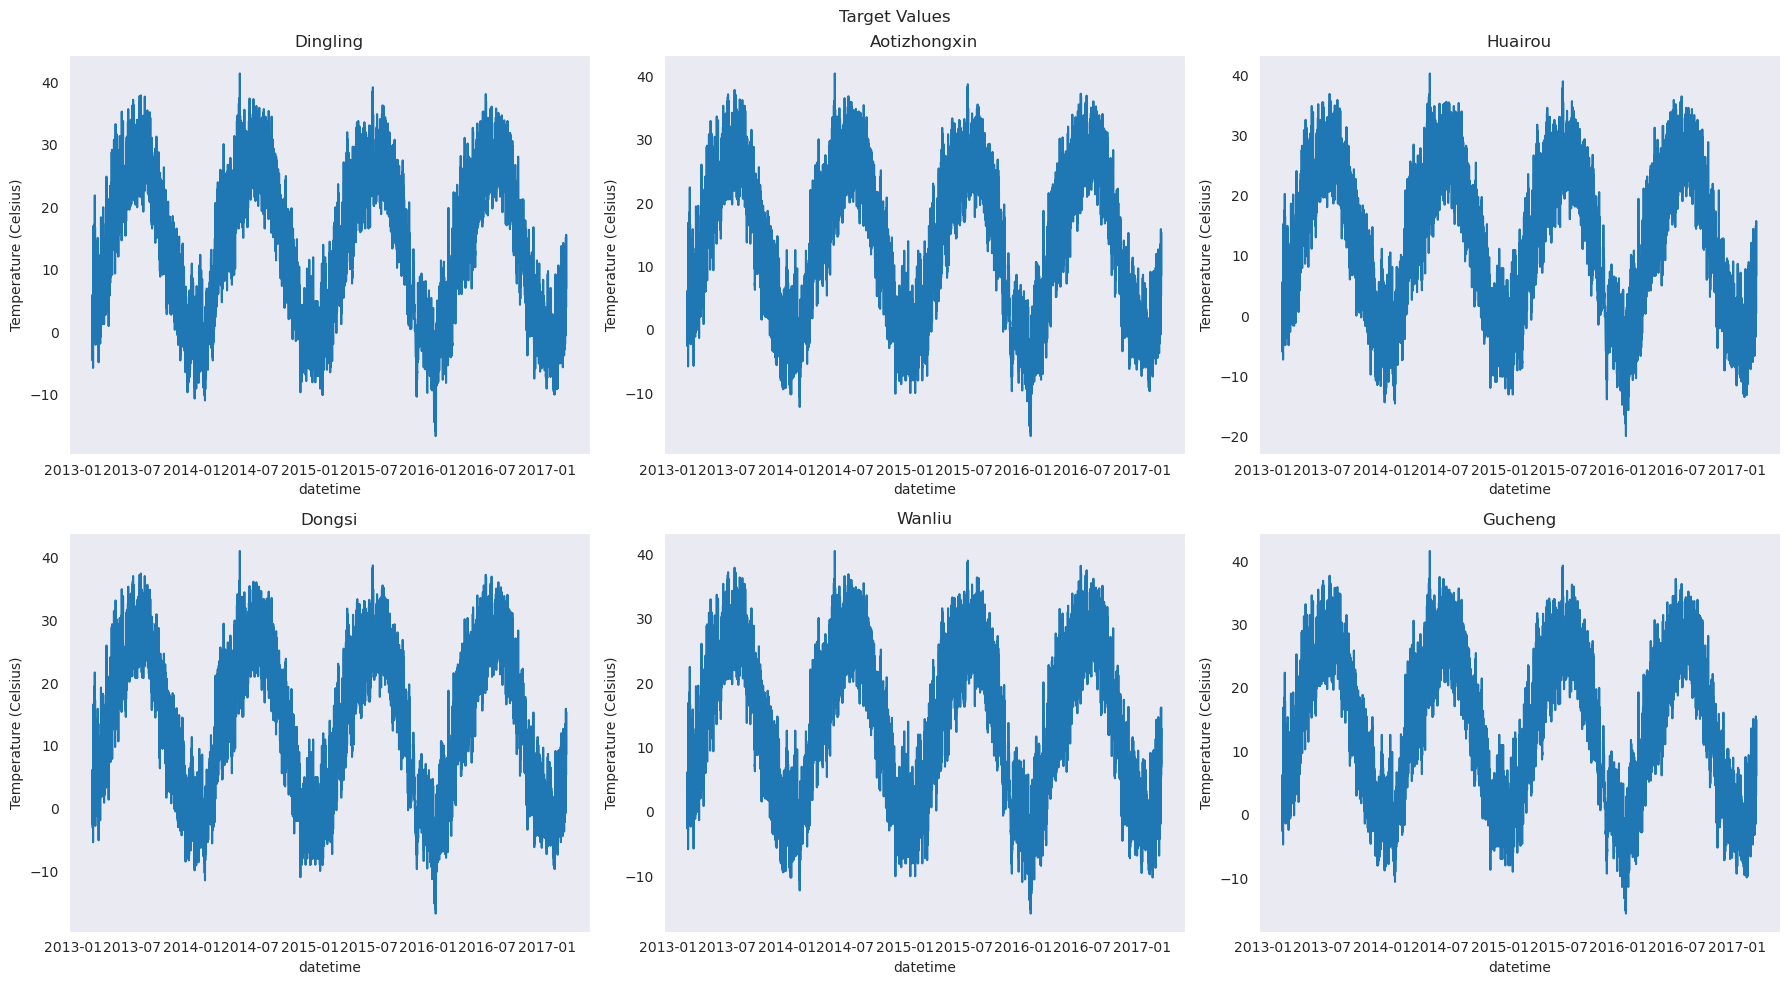

In [10]:
sns.set_style("dark")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Target Values")

for i, axis in zip(range(len(dataset))[:6], axes.ravel()):
    sns.lineplot(data=dataset[i], x="datetime", y="TEMP", ax=axis)
    axis.set_title(dataset[i]["station"].iloc[0])
    axis.set_ylabel("Temperature (Celsius)")
fig.tight_layout()

![Dataset Visual](./images/dataset_visual.png)

### Train/Test Split

Now we'll demonstrate how to use this dataset in **SageMaker DeepAR** and predict. 

SageMaker's DeepAR expects input in a JSON format with these specific fields for **each** time series:
- `start`
- `target`
- `cat` (optional)
- `dynamic_feat` (optional)

Further information about the DeepAR input formatting can be found here: [DeepAR Input/Output Interface](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput).

SageMaker DeepAR recommends a prediction length of `<=400` as large values decrease the algorithms accuracy and speed. Thus, let's set the length of our test time series and prediction length to the last two weeks of our data, or `14*24 = 336` observations. Useful information about best practices for DeepAR can be found here: [DeepAR Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices). Since we have missing values in our time series, we must account for these. Luckily, DeepAR accepts missing values as long as they're `"NaN"` strings or encoded as `null` literals, as we will be exporting our time series to `JSON` to train the DeepAR model. One could also choose to replace all missing values with the mean of each time series.

In [11]:
prediction_length = 14 * 24  # 14 days

deepar_training = [
    {
        "start": str(df["datetime"].min()),
        "target": df["TEMP"].fillna("NaN").tolist()[:-prediction_length],
    }
    for df in dataset
]

deepar_test = [
    {"start": str(df["datetime"].min()), "target": df["TEMP"].fillna("NaN").tolist()}
    for df in dataset
]

### Upload to S3

SageMaker DeepAR gets its data for training from S3, so we'll use the previously defined **Boto3 S3 Client** to upload our JSON files to **S3**. However, uploading files through the AWS console is another option and does not require code.

Let's define a function to export our dictionaries into JSON files to make our data properly input into SageMaker DeepAR:

In [12]:
def write_dicts_to_json(path, data):
    with open(path, "wb") as file_path:
        for ts in data:
            file_path.write(json.dumps(ts).encode("utf-8"))
            file_path.write("\n".encode("utf-8"))

Now we can export our dictionaries in a JSON format into the paths we defined earlier:

In [13]:
write_dicts_to_json(deepar_training_path, deepar_training)
write_dicts_to_json(deepar_test_path, deepar_test)

In [14]:
s3_client.upload_file(deepar_training_path, bucket, deepar_s3_training_path)
s3_client.upload_file(deepar_test_path, bucket, deepar_s3_test_path)

## Model

Now that we've formatted our data properly, we can train our model. When initializing our estimator, we must specify an instance type. Available options as well as pricing can be viewed here: [Available SageMaker Pricing](https://aws.amazon.com/sagemaker/pricing/). We also need to pass an Image URI to specify which algorithm we want to use, as well as pass required parameters to our `Estimator`. Further documentation on retrieving Image URIs and the `sagemaker.estimator.Estimator` class can be found here:

- [Image URI API](https://sagemaker.readthedocs.io/en/stable/api/utility/image_uris.html)

- [SageMaker Estimator API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In this case, it was found that an `ml.c5.2xlarge` had the minimum amount of memory required for the training to complete, but one should use any instance type that fits their use case. In addition, using faster **EC2** instances may in some cases be cheaper than using the minimum required as the model will take less time to train. Amazon SageMaker also offers discounted EC2 pricing if Amazon EC2 Spot instances are used, which is unused EC2 capacity in the AWS cloud. This can be toggled with the `use_spot_instances` parameter. Further information on Managed Spot Training can be found here: [Model Managed Spot Training](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)

In [16]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region)
role = sagemaker.get_execution_role()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    base_job_name="DEMO-DeepAR",
    use_spot_instances=False,
    output_path="s3://{}/{}".format(bucket, deepar_s3_output_path),
)

[03/16/25 13:53:29] INFO     Same images used for training and inference. Defaulting to image     ]8;id=318414;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=694471;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=901512;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=807918;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Now we need to configure the DeepAR instance's hyperparameters to our specific needs. There are four required hyperparameters that we must define, but there are 16 total tunable hyperparameters. All tunable hyperparameters and detailed descriptions can be found here: [DeepAR Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).



In [17]:
hyperparameters = {
    "epochs": "5",
    "time_freq": "H",
    "prediction_length": prediction_length,
    "context_length": prediction_length,
}

estimator.set_hyperparameters(**hyperparameters)

After setting the hyperparameters, we can train our model. One run of the training job took `1543 seconds`, or approximately `25 minutes`.

In [18]:
%%time
estimator.fit(
    inputs={
        "train": "s3://{}/{}".format(bucket, deepar_s3_training_path),
        "test": "s3://{}/{}".format(bucket, deepar_s3_test_path),
    }
)

[03/16/25 13:53:33] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=298877;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=391871;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: DEMO-DeepAR-2025-03-16-13-53-33-944   ]8;id=521994;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=903682;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-03-16 13:53:35 Starting - Starting the training job...
..25-03-16 13:54:05 Downloading - Downloading input data.
........16 13:54:20 Downloading - Downloading the training image.
2025-03-16 13:55:46 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[03/16/2025 13:56:02 INFO 140498361739072] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'm

## Inference

After training our model, we must initialize an endpoint to call our model. This particular endpoint uses an `ml.c5.large` instance and took `3 minutes 2 seconds` to initialize.

In [19]:
%%time
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.c5.large",
    image_uri=image_uri,
    role=role,
)

[03/16/25 14:24:00] INFO     Creating model with name: DEMO-DeepAR-2025-03-16-13-53-33-944          ]8;id=387256;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=412070;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/16/25 14:24:01] INFO     Creating endpoint-config with name DEMO-DeepAR-2025-03-16-13-53-33-944 ]8;id=773983;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=818744;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4539\4539]8;;\

                    INFO     Creating endpoint with name DEMO-DeepAR-2025-03-16-13-53-33-944        ]8;id=327009;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=24324;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

--------!CPU times: user 109 ms, sys: 9.31 ms, total: 118 ms
Wall time: 4min 32s


Then, we can initialize a predictor from our endpoint to receive time series predictions:

In [20]:
from sagemaker.serializers import JSONSerializer

predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sagemaker_session, serializer=JSONSerializer()
)

**DeepAR** requires our request be in a `JSON` request format as input to receive predictions. The following example is from the [DeepAR JSON Request Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) documentation page where request definition is outlined:

    {
        "instances": [
            {
                "start": "2009-11-01 00:00:00",
                "target": [4.0, 10.0, "NaN", 100.0, 113.0],
                "cat": [0, 1],
                "dynamic_feat": [[1.0, 1.1, 2.1, 0.5, 3.1, 4.1, 1.2, 5.0, ...]]
            },
            {
                "start": "2012-01-30",
                "target": [1.0],
                "cat": [2, 1],
                "dynamic_feat": [[2.0, 3.1, 4.5, 1.5, 1.8, 3.2, 0.1, 3.0, ...]]
            },
            {
                "start": "1999-01-30",
                "target": [2.0, 1.0],
                "cat": [1, 3],
                "dynamic_feat": [[1.0, 0.1, -2.5, 0.3, 2.0, -1.2, -0.1, -3.0, ...]]
            }
        ],
        "configuration": {
             "num_samples": 50,
             "output_types": ["mean", "quantiles", "samples"],
             "quantiles": ["0.5", "0.9"]
        }
    }
    
Only types specified in the request will be present in the predictor's response. Valid values for the `output_types` field are: `"mean"`,`"quantiles"`, and `"samples"`. Furthermore, the `"cat"` and/or `"dynamic_feat"` fields of each instance should be omitted if these fields were not used to train the model. Let's define our request, where we'll request predictions for the `0.1`, `0.5`, and `0.9` quantiles.

In [21]:
predictor_input = {
    "instances": deepar_training,
    "configuration": {"output_types": ["quantiles"], "quantiles": ["0.1", "0.5", "0.9"]},
}

Finally, we can obtain a prediction from our model for the `prediction_length` number of instances following our requested time series, and conforming to the `time_freq` (time frequency) specified in our hyperparameters. This prediction took approximately `8 seconds` to receive a response.

In [22]:
%%time
prediction = predictor.predict(predictor_input)

CPU times: user 124 ms, sys: 19.9 ms, total: 144 ms
Wall time: 8.58 s


### Interpreting Results
The resulting prediction will come in a `JSON` format. The response is within a dictionary formatted like so: [DeepAR JSON Response Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html#deepar-json-response). The following example is from the previously mentioned page:

    {
        "predictions": [
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            },
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            },
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            }
        ]
    }

Let's define a method to help us decode the predictor's `JSON` response and load it onto a DataFrame:

In [23]:
def prediction_to_df(response):
    data = json.loads(response)
    dataframes = []

    for ts in data["predictions"]:
        if "quantiles" in ts:
            # Since the quantiles response comes in a list within the dictionary, we will append the quantiles
            # dictionary of each time series to the mean and samples(if requested) of those respective time series
            ts.update(ts["quantiles"])
            ts.pop("quantiles")
        dataframes.append(pd.DataFrame(data=ts))

    return dataframes

Now that we've obtained our predictions(that came in a `JSON` format) and defined a method to decode these predictions, we can see our results in a pandas `DataFrame` format:

In [24]:
deepar_results = prediction_to_df(prediction)

display(deepar_results[0])

,0.1,0.5,0.9
0,-3.201471,1.554473,6.490248
1,-3.568170,0.112761,4.634046
2,-5.259938,-0.099892,3.323865
3,-5.543558,-0.043421,4.195652
4,-5.758895,-0.501620,3.981005
...,...,...,...
331,2.513070,5.082222,7.588710
332,2.906651,4.957954,6.855177
333,2.009144,4.243437,6.570006
334,0.872328,3.757290,6.445302


Let's visualize our predictions after acquisition. We'll plot our first station to see how we did. First, let's append our `target` values to our results for convenient comparison. Then, we'll plot all requested quantiles onto the same plot with the `target` values to see how DeepAR did.

In [25]:
df_results = []

for i in range(len(deepar_results)):
    temp = pd.concat(
        [
            dataset[i][["TEMP", "datetime", "station"]]
            .tail(prediction_length)
            .reset_index(drop=True),
            deepar_results[i],
        ],
        axis=1,
    )
    temp = temp.rename(columns={"TEMP": "target"})
    df_results.append(temp)

In [26]:
def plot_comparison(query):
    sns.set_style("dark")
    plt.figure(figsize=(18, 10))
    plt.plot(query["datetime"], query["0.1"], color="r", lw=1)
    plt.plot(query["datetime"], query["0.5"], color="orange", linestyle=":", lw=2)
    plt.plot(query["datetime"], query["0.9"], color="r", lw=1)
    plt.plot(query["datetime"], query["target"], color="b", lw=1)
    plt.fill_between(
        query["datetime"].tolist(),
        query["0.9"].tolist(),
        query["0.1"].tolist(),
        color="y",
        alpha=0.5,
    )
    plt.title(query["station"][0])
    plt.xlabel("Datetime")
    plt.ylabel("Temperature (Celsius)")

    plt.legend(["10% Quantile", "50% Quantile", "90% Quantile", "Target"])
    plt.show()

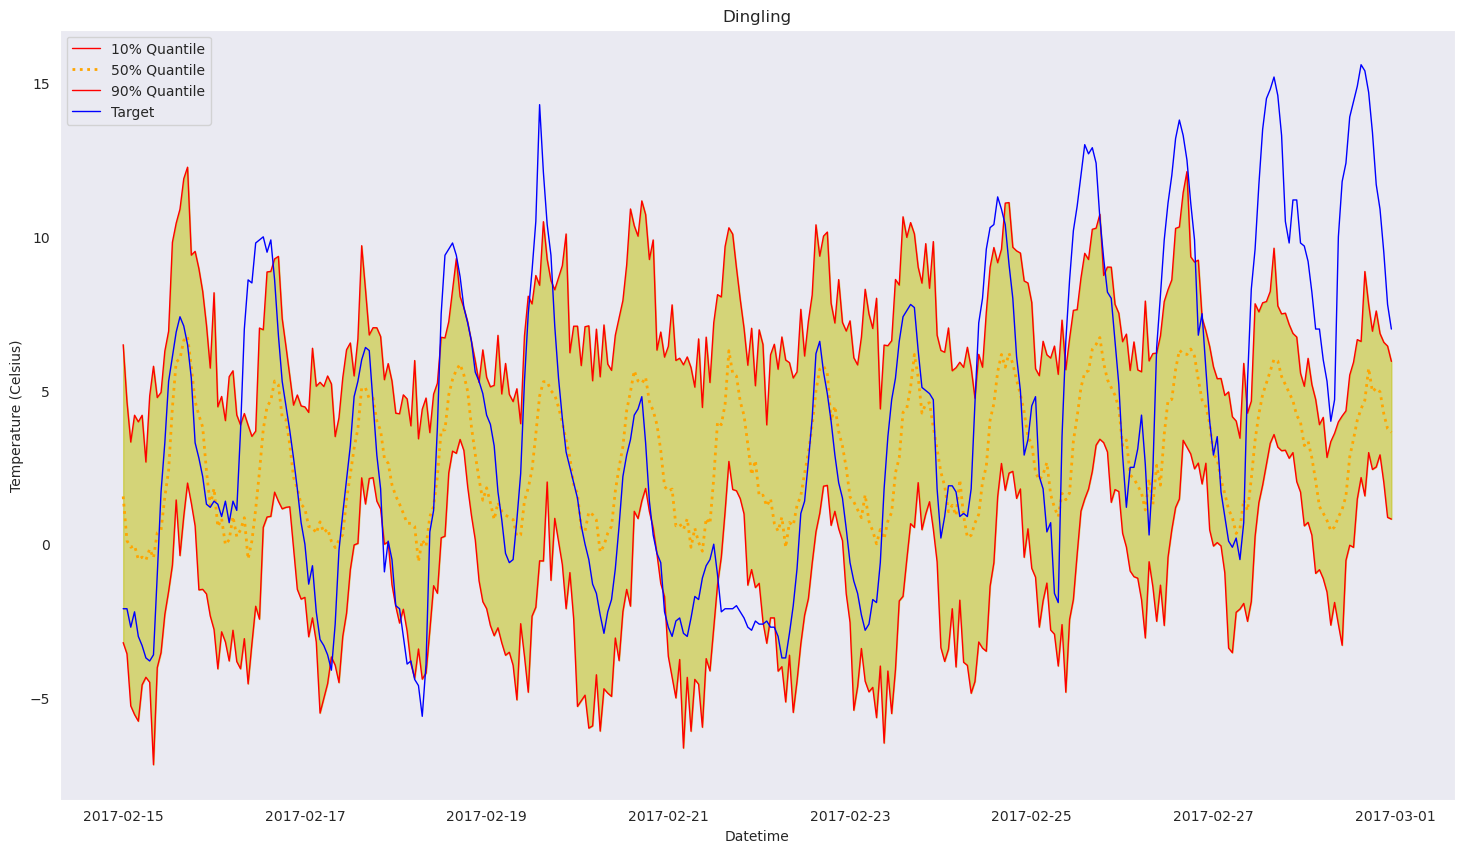

In [27]:
plot_comparison(df_results[0])

![DeepAR Results](./images/deepar_results.png)

As we can see, the 0.1 and 0.9 quantiles create an 80% confidence interval for our predictions, which our target generally stays within. However, as mentioned in the [DeepAR Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices), our confidence interval becomes less accurate towards the end due to our relatively high `prediction_length` value. To remediate this, lowering the frequency of data, such as changing `1min` to `5min`, or `H` to `D` (hourly to daily), is recommended.

## Resource Cleanup

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

## Next Steps
This notebook illustrates the features offered by **DeepAR on SageMaker**, and is part of the [Time Series Modeling with Amazon Forecast and DeepAR on SageMaker](.) series. The notebook series aims to demonstrate how to use the **Amazon Forecast** and **DeepAR on SageMaker** time series modeling services as well as outline their features. Be sure to read the [Amazon Forecast](./forecast_example.ipynb) example, and view a top-level comparison of both services in the [README](./README.md).

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|forecasting_services_comparison|deepar_example.ipynb)
